#### Script to diagnose and plot Buoyancy metric from Ahmed et al. 2020.

James Ruppert  
jruppert@ou.edu  
7/15/23

In [1]:
from netCDF4 import Dataset
import numpy as np
# matplotlib.use('pdf')
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, rc
import pandas as pd
# from thermo_functions import mixr_sat

In [ ]:
# #### Main settings

# NOTE: Using copied tracking from CTL for NCRF tests

storm = 'haiyan'
# storm = 'maria'

# How many members
nmem = 10 # number of ensemble members
# nmem = 2

# #### Directories

figdir = "/home/jamesrup/figures/tc/ens/time_series/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"

# Tests to read and compare
ntest=2
if storm == 'haiyan':
    tests = ['ctl','ncrf36h']
elif storm == 'maria':
#        tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']

In [ ]:
# Prep tests & ens members

def get_tshift(itest):
    if itest == 'ctl':
        tshift=0
    elif itest == 'ncrf36h':
        tshift=36
    elif itest == 'ncrf48h':
        tshift=48
    return tshift

# Ens member strings
memb0=1 # Starting member to read
nums=np.arange(memb0,nmem+memb0,1)
nums=nums.astype(str)
nustr = np.char.zfill(nums, 2)
memb_all=np.char.add('memb_',nustr)

datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'
varfil_main = Dataset(datdir+'post/d02/T.nc')
pres = varfil_main.variables['pres'][:]
varfil_main.close()
nz=pres.shape[0]
dp = (pres[0]-pres[1])*1e2 # Pa

nt = np.zeros(ntest, dtype=np.int32)
for itest in range(ntest):
    ##### Get dimensions
    datdir = main+storm+'/'+memb_all[0]+'/'+tests[itest]+'/'
    varfil_main = Dataset(datdir+'post/d02/T.nc')
    i_nt = varfil_main.dimensions['time'].size
    varfil_main.close()
    nt[itest]=i_nt

---
#### Variable read functions

In [ ]:
def get_condavg_settings():
    
    condavg_label = [
        'all',      # All unmasked points
        # 'non-precip',
        'deep',
        'cong',
        'shall',
        'strat',
        'anvil',
        'deepcong', # deep + cong
        'stratanv', # strat + anv
        'allrain',  # deep + cong + strat + anv
        # 'upward',   # upward-motion-weighted
        # 'downward', # downward-motion-weighted
        ]

    condavg_title = [
        'All',
        # 'Non Precip',
        'Dc',
        'Cg',
        'Sh',
        'St',
        'An',
        'Dc+Cg',
        'St+An',  
        'Dp+Cg+St+An',
        # 'Upward',
        # 'Downward',
        ]

    return condavg_label, condavg_title

condavg_label, condavg_title = get_condavg_settings()
ncond = len(condavg_label)

In [ ]:
def read_var(datdir, varname, iktop):
    readfile = Dataset(datdir+varname)
    var = readfile.variables[varname][:, :iktop+1, :, :]
    readfile.close()
    return var

#### Lower and Middle troposphere indices  
Based on Ahmed, Adames, Neelin (2020, JAS)  

B: DBL (deep boundary layer)  
L: LFT (lower free trop)  

In [ ]:
# Layer-average pressures
p_B = 92500. # Pa
p_L = 72500. # Pa
dp_B = (1000-850)*1e2
dp_L = (850-600)*1e2

# Pi-tilde (mean Exner function)
c_p = 1004 # J/K/kg
r_d = 287 # J/K/kg
pi_t = (p_L/p_B)**(r_d/c_p)

# Scaling parameters
w_B = (dp_B/dp_L) * np.alog((dp_B + dp_L)/dp_B)
w_L = 1 - w_B
print('w_B = ',w_B)
print('w_L = ',w_L)

# Layer indices
ind_B = np.where((pres >= 850))
ind_L = np.where((pres <= 850) & (pres >= 600))
print(pres[ind_B])

# Only read up to top-level needed
iktop = np.where(pres >= 600)
print(iktop)
print(pres[iktop])

# Layer averages
def calc_vavg(var):
    return np.mean(var, axis=1)
def vavg_B(var):
    return calc_vavg(var[:,ind_B,...])
def vavg_L(var):
    return calc_vavg(var[:,ind_L,...])

---
#### Loop over tests and ensemble members, reads and processes variables via the functions above.

In [ ]:
# Create arrays

# Time index set based on TEST 0 (e.g., CTL)

shape = (ntest,nmem,ncond,nt[0],nz)
buoy_sav = np.full(shape, np.nan, dtype=np.float64)

#### Main loops

for itest in range(ntest):
# for itest in range(1):

    tshift = get_tshift(tests[itest])
    times_itest = np.arange(tshift, nt[itest]+tshift, 1)

    for imemb in range(nmem):
    # for imemb in range(1):

        datdir = main+storm+'/'+memb_all[imemb]+'/'+tests[itest]+'/post/d02/'

        # Read variables
        # GET FROM WRITE_MSE
        tmpk = read_var(datdir, 'tmpk', iktop)
        qv = read_var(datdir, 'QVAPOR', iktop)
        lv=lv
        qv_sat = mixr_sat(tmpk, pres[np.newaxis, :, np.newaxis, np.newaxis])

        # Moist enthalpies
        c_pT = c_p*tmpk
        me     = c_pT + (l_v * qv)
        me_sat = c_pT + (l_v * qv_sat)
        me_sat_L = vavg_L(me_sat)

        term1 = ((pi_t * vavg_B(me)) - me_sat_L) * w_B / me_sat_L
        term2 = (vavg_L(qv_sat) - vavg_L(qv)) * w_L*L_v/me_sat_L
        buoy = g*(term1 - term2)

        # Conduct conditional averaging

        # Save averaged results

        buoy_sav[itest, imemb, :, tshift:nt[itest]+tshift, :] = buoy_avg

---
#### Plotting routines

In [ ]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

rc('font', **font)

#### Vertical profiles

In [ ]:
# Function to plot class-averaged profiles
def plot_profiles(var_profiles, precip_list, xlabel, pres, zeroline=True):
    fig = plt.figure(figsize=(12,8),facecolor='white')

    # Profile 1
    ax = fig.add_subplot(121)

    ax.plot(var_profiles[0,1], pres, label=precip_list[1], color='blue')
    ax.plot(var_profiles[1,1], pres, label=precip_list[1], color='blue', linestyle='dashed')
    ax.plot(var_profiles[0,2], pres, label=precip_list[2], color='red')
    ax.plot(var_profiles[1,2], pres, label=precip_list[2], color='red', linestyle='dashed')
    ax.plot(var_profiles[0,3], pres, label=precip_list[3], color='green')
    ax.plot(var_profiles[1,3], pres, label=precip_list[3], color='green', linestyle='dashed')
    ax.plot(var_profiles[0,6], pres, label=precip_list[6], color='black')
    ax.plot(var_profiles[1,6], pres, label=precip_list[6], color='black', linestyle='dashed')
    
    ax.set_title('Convective', size=16, weight='bold')
    plt.legend(loc='upper right', fontsize=12)
    plt.gca().invert_yaxis()
    if zeroline: ax.axvline(0, color='gray', linestyle='--')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ytick_loc=np.arange(1000,0,-100)
    plt.yticks(ticks=ytick_loc, size=12)
    plt.ylim(1000, 100)
    # plt.xlim(-0.25,1.25)
    plt.xticks(size=12)
    plt.xlabel(xlabel, size=14, weight='bold')
    plt.ylabel('Pressure [hPa]', size=14, weight='bold')

    # Profile 2
    ax = fig.add_subplot(122)
    ax.plot(var_profiles[0,4], pres, label=precip_list[4], color='blue')
    ax.plot(var_profiles[1,4], pres, label=precip_list[4], color='blue', linestyle='dashed')
    ax.plot(var_profiles[0,5], pres, label=precip_list[5], color='red')
    ax.plot(var_profiles[1,5], pres, label=precip_list[5], color='red', linestyle='dashed')
    ax.plot(var_profiles[0,7], pres, label=precip_list[7], color='black')
    ax.plot(var_profiles[1,7], pres, label=precip_list[7], color='black', linestyle='dashed')

    ax.set_title('Stratiform', size=16, weight='bold')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    plt.legend(loc='upper right', fontsize=12)
    plt.gca().invert_yaxis()
    if zeroline: ax.axvline(0, color='gray', linestyle='--')
    plt.ylim(1000,100)
    # plt.xlim(-0.25,0.4)
    plt.yticks(ticks=ytick_loc, size=12)
    plt.ylim(1000, 100)
    plt.xticks(size=12)
    plt.xlabel(xlabel, size=14, weight='bold')
    plt.ylabel('Pressure [hPa]', size=14, weight='bold')

In [ ]:
xlabel='MSE [kJ/kg]'
iktop = np.where(pres >= 100)[0].max()+1
plot_profiles(mse_sav[:,0,:,50,:iktop]*1e-3, condavg_title, xlabel, pres[:iktop], zeroline=False)

In [ ]:
xlabel='VADV MSE [J/kg/s]'
iktop = np.where(pres >= 100)[0].max()+1
plot_profiles(vadv_mse_sav[:,0,:,50,:iktop], condavg_title, xlabel, pres[:iktop], zeroline=True)

#### Time series

In [ ]:
# Vertically integrate

def vert_int(invar, dp):
    # Vertically integrate: 1/g * SUM(var*dp)
    # Negative is absorbed by dp>0
    g = 9.81 # m/s2
    var_sum = np.sum(invar, axis=-1)*dp/g
    return var_sum

vadv_mse_vint = vert_int(vadv_mse_sav, dp)
mse_vint = vert_int(mse_sav, dp)

var_list = [mse_vint, vadv_mse_vint]
var_stack = np.stack(var_list, axis=0)

##### Time series comparing tests

In [ ]:
tshift = get_tshift(tests[itest])
times_ncrf = np.arange(tshift, nt[itest]+tshift, 1)

for ivar in range(2):

    var0_ivar = var_stack[ivar, 0, ...]
    var1_ivar = var_stack[ivar, 1, ...]
    var0_ivar = var0_ivar[:, :, times_ncrf]
    var1_ivar = var1_ivar[:, :, times_ncrf]
    figtag = var_names[ivar]
    ylabel = units[ivar]

    for icond in range(ncond):

        fig_extra=condavg_label[icond]
        condtag=fig_extra #condavg_title[icond]
        print(fig_extra)

        var0 = np.copy(var0_ivar[:, icond, :])
        var1 = np.copy(var1_ivar[:, icond, :])

        if figtag == 'mse':
            title_tag = '$h$'
        elif figtag == 'vadv_mse':
            title_tag = 'VADV($h$) (Eul.)'

    #----------------------------------------------------------------

        # Use Pandas to smooth via running mean
        var0 = pd.DataFrame(var0)
        var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
        var1 = pd.DataFrame(var1)
        var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()

        # create figure
        fig = plt.figure(figsize=(6,3))
        ax = fig.add_subplot(111)

        ax.set_title(title_tag+' ('+condtag+')')#, fontsize=20)
        ax.set_ylabel(ylabel)
        ax.set_xlabel('Time [hours]')

        t_range=[times_ncrf[0], times_ncrf[-1]]
        # plt.xlim(t_range)

        color_t0 = 'red'
        color_t1 = 'blue'

        # Test 0

        mean_t0 = np.nanmean(var0, axis=0)
        std_t0 = np.nanstd(var0, axis=0)

        xdim = times_ncrf

        plt.plot(xdim, mean_t0, linewidth=2, label=tests[0].upper(), color=color_t0, linestyle='solid')
        plt.fill_between(xdim, mean_t0 + std_t0, mean_t0 - std_t0, alpha=0.2, color=color_t0)

        # Test 1

        mean_t1 = np.nanmean(var1, axis=0)
        std_t1 = np.nanstd(var1, axis=0)

        plt.plot(xdim, mean_t1, linewidth=2, label=tests[0].upper(), color=color_t1, linestyle='solid')
        plt.fill_between(xdim, mean_t1 + std_t1, mean_t1 - std_t1, alpha=0.2, color=color_t1)

        plt.grid()

        # plt.legend(loc="upper right")

        figdir2 = figdir+'all/'
        figname=figdir2+'tser_'+storm+'_'+figtag+'_'+fig_extra+'.png'
        plt.savefig(figname,dpi=200, facecolor='white', \
                    bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()

##### Time series showing the normalized change

In [95]:
mse_vint.shape

(2, 10, 9, 97)

all


/tmp/ipykernel_1939/1547708274.py:50: RuntimeWarning: Mean of empty slice
  mean_t0 = np.nanmean(var0, axis=0)
/home/jamesrup/miniconda3/envs/plotting/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


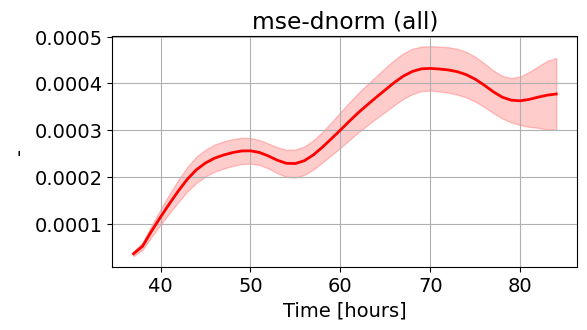

deep


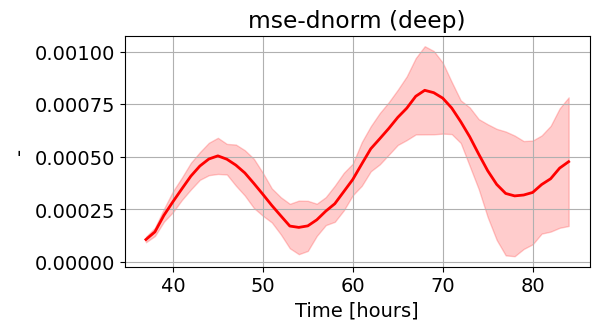

cong


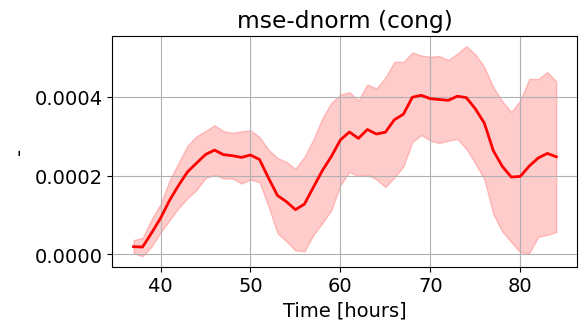

shall


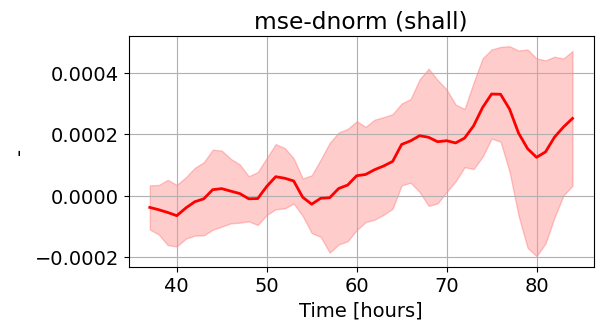

strat


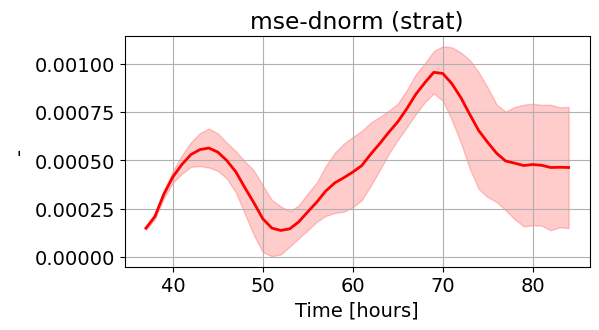

anvil


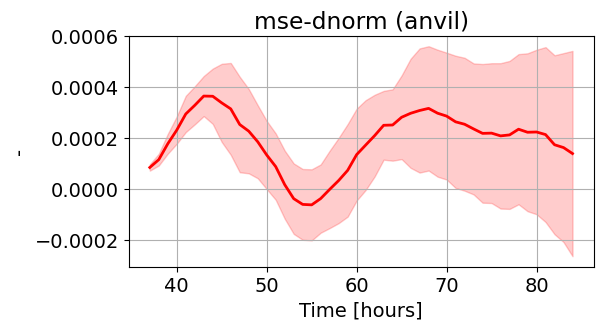

deepcong


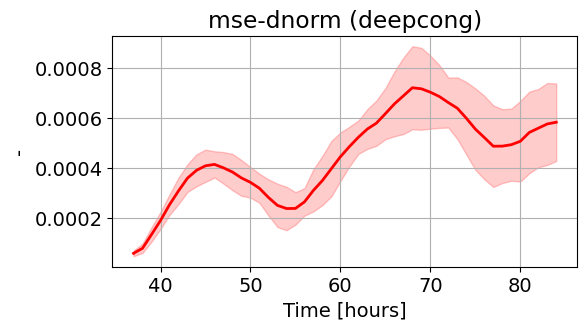

stratanv


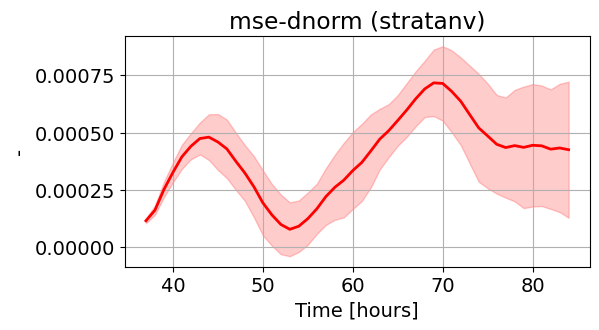

allrain


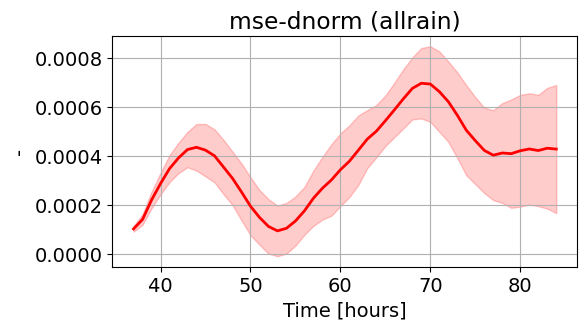

all


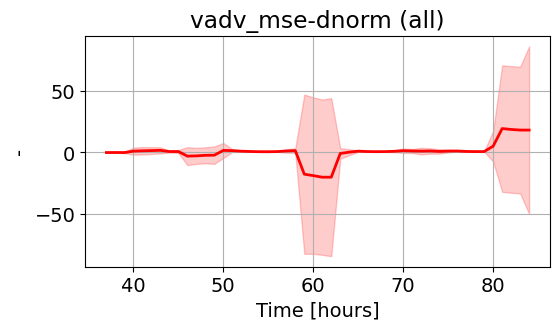

deep


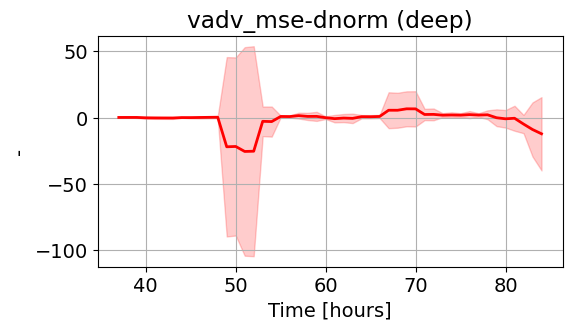

cong


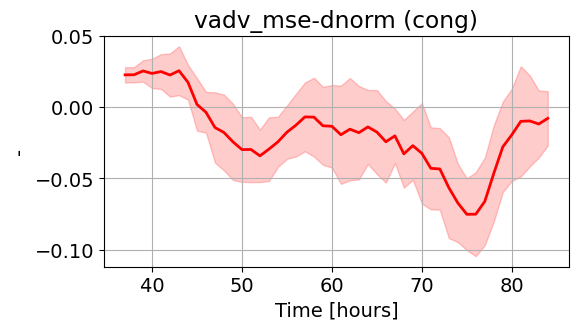

shall


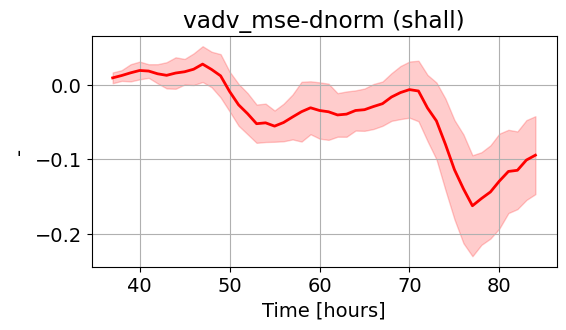

strat


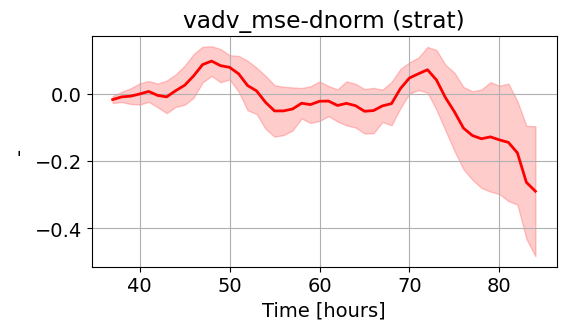

anvil


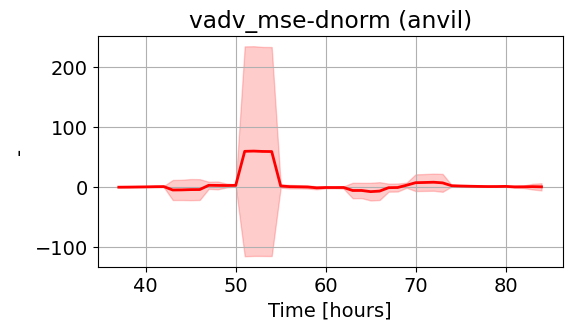

deepcong


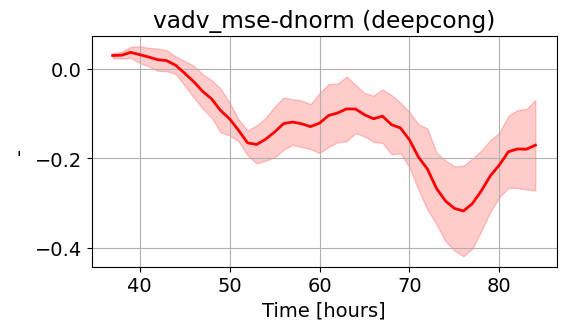

stratanv


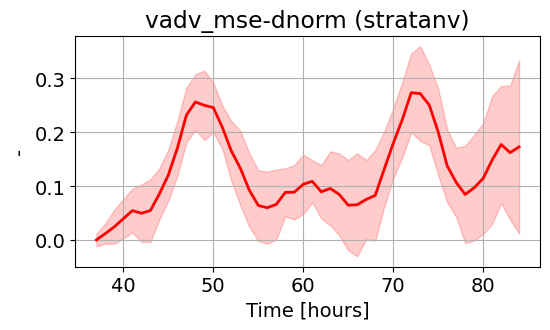

allrain


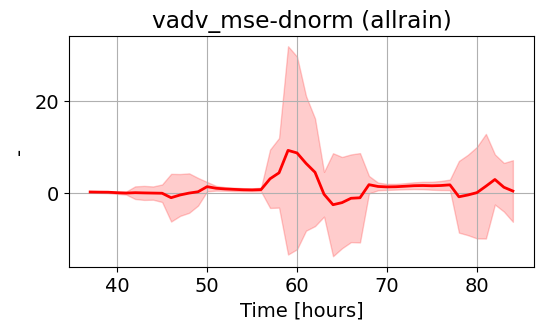

In [101]:
tshift = get_tshift(tests[itest])
times_ncrf = np.arange(tshift, nt[itest]+tshift, 1)

for ivar in range(2):

    var0_ivar = var_stack[ivar, 0, ...]
    var1_ivar = var_stack[ivar, 1, ...]
    var0_ivar = var0_ivar[:, :, times_ncrf]
    var1_ivar = var1_ivar[:, :, times_ncrf]

    var_plot = (var0_ivar - var1_ivar) / var0_ivar

    figtag = var_names[ivar]+'-dnorm'
    ylabel = '-' # units

    for icond in range(ncond):

        fig_extra=condavg_label[icond]
        condtag=fig_extra #condavg_title[icond]
        print(fig_extra)

        var0 = np.copy(var_plot[:, icond, :])

        title_tag = figtag

    #----------------------------------------------------------------

        # Use Pandas to smooth via running mean
        var0 = pd.DataFrame(var0)
        var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
        var1 = pd.DataFrame(var1)
        var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()

        # create figure
        fig = plt.figure(figsize=(6,3))
        ax = fig.add_subplot(111)

        ax.set_title(title_tag+' ('+condtag+')')#, fontsize=20)
        ax.set_ylabel(ylabel)
        ax.set_xlabel('Time [hours]')

        t_range=[times_ncrf[0], times_ncrf[-1]]
        # plt.xlim(t_range)

        color_t0 = 'red'
        color_t1 = 'blue'

        # Test 0

        mean_t0 = np.nanmean(var0, axis=0)
        std_t0 = np.nanstd(var0, axis=0)

        xdim = times_ncrf

        plt.plot(xdim, mean_t0, linewidth=2, label=tests[0].upper(), color=color_t0, linestyle='solid')
        plt.fill_between(xdim, mean_t0 + std_t0, mean_t0 - std_t0, alpha=0.2, color=color_t0)

        plt.grid()

        # plt.legend(loc="upper right")

        figdir2 = figdir+'all/'
        figname=figdir2+'tser_'+storm+'_'+figtag+'_'+fig_extra+'.png'
        plt.savefig(figname,dpi=200, facecolor='white', \
                    bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()